<a href="https://colab.research.google.com/github/dxcim/Business-Analytics-Foundations/blob/main/m4_3_pattern_recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Module 4 | Pattern discovery**

`m4_3_pattern_recog.ipynb` | 2025-03-25 11:47

# Pattern recognition with Python

In this demonstration we will use PyCaret to find patterns in customer churn data and predict which customers are likely to churn. We'll load the data, explore it with some visualisations, and then build a model to predict customer churn.

Churn is the word used in some industries, especially telecommunications, to describe when a customer leaves a service. In other industries you'll hear "attrition" or "customer turnover". It's a big problem because it's much more expensive to find new customers than to keep existing ones.

Companies spend a lot of time and money trying to predict which customers are likely to churn, so they can take action to keep them. This is a classic predictive analytics problem. We need accurate predictions plus an understanding of what causes churn because:

* If the plan is to contact customers to try to keep them, we need to know what to say
* If the plan is to offer incentives, we don't want to offer them to customers who would stay anyway
* We don't have capacity to contact every customer, so we need to prioritise
* Customers on the whole don't like being contacted, so we need to be right

We can use information about past customers to understand what causes churn, and then use that information to predict churn for new customers.

## How to use this notebook


To run this notebook in Colab, choose **Runtime** from the top menu and then **Run all**. This will set up the notebook and then run all the cells.

The first run may take a few minutes to install the required libraries and download the data. Subsequent runs will be faster.

You can also run the cells one by one using the play button next to each cell.

---

This section of the notebook contains code to set up the notebook environment. It installs the required libraries, downloads the data, and sets the display style for charts.

After this section of the notebook runs successfully, you can hide the cells in this section. To do this in Colab, choose **View** from the top menu, then **Collapse sections**, or click the downward chevron ⌄ next to the section title.

You do not need to understand the code in the "How to use this notebook" section to follow the rest of the notebook.


In [1]:
# install PyCaret

# if prompted by Colab, restart the runtime after installing: Runtime -> Restart session
# if you see: "ERROR: pip's dependency resolver does not currently take into account all the packages that are installed",
# and you have NOT tried restarting the runtime, you should restart the runtime. Otherwise, you can ignore this message.

%pip install --upgrade --quiet pycaret

In [2]:
# download data

from urllib.request import urlretrieve
from pathlib import Path

if not Path("/content/telco_churn.csv").exists():
    urlretrieve("https://canvas.uts.edu.au/files/8948576/download?download_frd=1&verifier=tCFgJNhNSbLOD8HE0tcMlnPQum6mzGzNQrstwmA8", "telco_churn.csv")

if not Path("/content/telco_churn_new_custs.csv").exists():
    urlretrieve("https://canvas.uts.edu.au/files/8948577/download?download_frd=1&verifier=JVFAFLeXzrTDWKbVERl4KGLgYW2zvsvquG3OrZHs", "telco_churn_new_custs.csv")

if not Path("/content/telco_churn_new_custs_actual.csv").exists():
    urlretrieve("https://canvas.uts.edu.au/files/8948578/download?download_frd=1&verifier=h4a9gB0womFYhi4joMRrwheUuKuiDsVMkQpKHqP5", "telco_churn_new_custs_actual.csv")

In [3]:
# format figures for display in Canvas

import seaborn as sns

sns.set_theme(style="white", rc={"figure.figsize": (12, 6)})
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})

# in Colab, if this cell fails with
# "ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject"
# first try restarting the runtime.
# To restart the runtime, use the menu: Runtime menu -> Restart runtime
# or use the keyboard shortcut Ctrl-M then . (period) and confirm. Mac: ⌘-M then . (period).
# Then re-run this cell.

## Data understanding

First, let's load the data and take a look.

In [4]:
import pandas as pd

# load the data
df = pd.read_csv('/content/telco_churn.csv')

# show the number of rows
print(f"Rows: {len(df)}")

# show the number of columns and their names
print(f"Columns ({len(df.columns)}):", ', '.join(df.columns))

# show example columns from the first few rows
df[['tenure', 'Dependents', 'TotalCharges', 'Contract', 'Churn']].head()

Rows: 6691
Columns (21): customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn


,tenure,Dependents,TotalCharges,Contract,Churn
0,1,No,29.85,Month-to-month,No
1,34,No,1889.50,One year,No
2,2,No,108.15,Month-to-month,Yes
3,45,No,1840.75,One year,No
4,2,No,151.65,Month-to-month,Yes


The variable we're interested in is `Churn`, which indicates whether a customer has left the service. The other variables are potential predictors of churn.

## Looking for relationships with visualisations

Are there patterns in the data that can help us predict churn? Let's explore the data with some visualisations.

We do this because:

* it's new data that we don't know much about
* visualisations can show us patterns so we know what to expect from a model
* it provides more examples of how to use seaborn

### Churn by contract type

First, is contract type related to churn?

<Axes: xlabel='Contract', ylabel='count'>

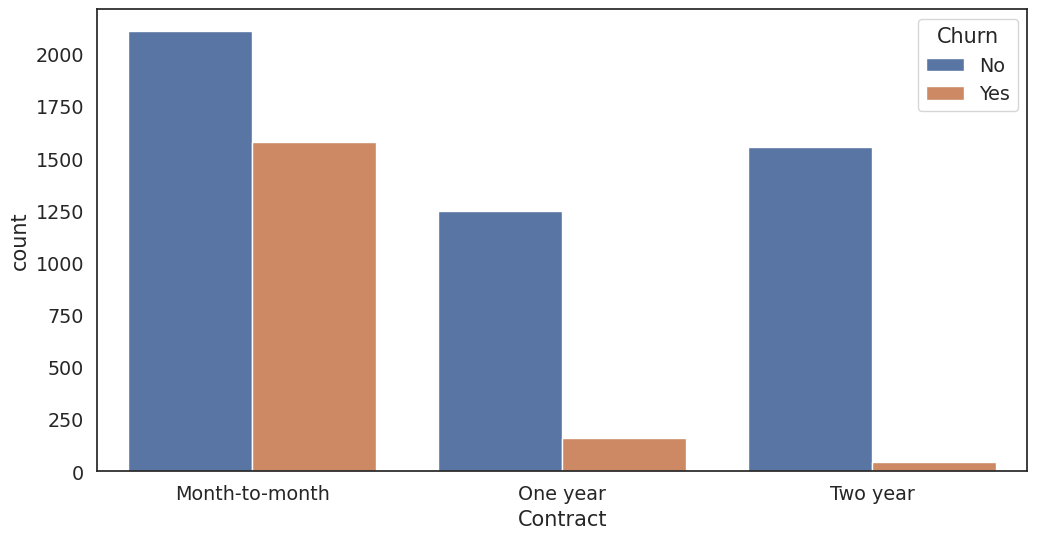

In [5]:
# bar chart of churn by contract type

sns.countplot(data=df, x='Contract', hue='Churn')

Yes, customers on month-to-month contracts are more likely to churn.

### Churn by tenure

What about tenure, which is the number of months a customer has stayed with the service?

<Axes: xlabel='tenure', ylabel='Count'>

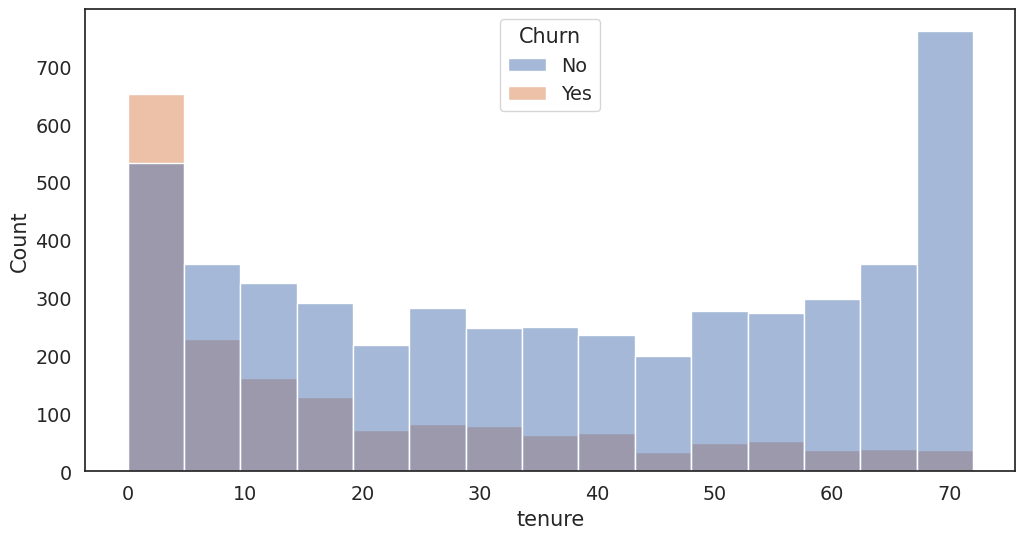

In [6]:
# overlaid histograms of tenure for churned and retained customers

sns.histplot(data=df, x='tenure', hue='Churn')

Definitely a pattern here: the longer the tenure, the less likely a customer is to churn.

It's easier to see if we think in terms of churn rates rather than counts. Let's show proportions instead of counts.

Text(0, 0.5, 'Churn rate')

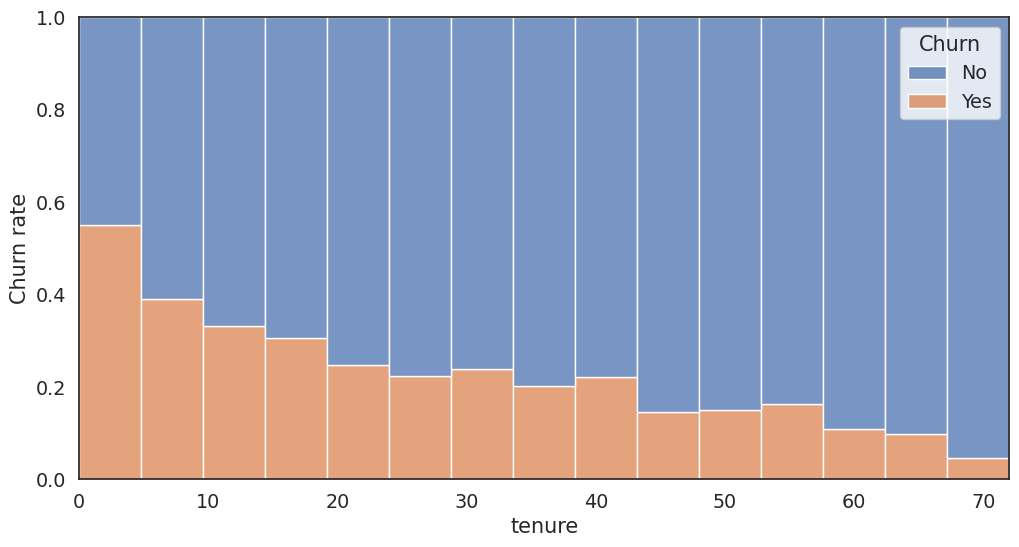

In [7]:
# histogram of tenure, with churn rates

sns.histplot(data=df, x='tenure', hue='Churn', multiple="fill").set_ylabel("Churn rate")

Proportion of churned customers decreases with tenure. This seems like a strong predictor of churn.

> [!tip] Proportion histograms are very useful when the counts of two groups are very different. They show the proportion of each group for each value bin of the variable, rather than the count. This makes it easier to compare the groups. But don't reach for them automatically - you do also need to know the counts. Otherwise you may find that churn rate is 100% for some value of tenure, without noticing that you are talking about one single customer.

### Churn by monthly charges

What about monthly charges? Are customers with higher monthly charges more likely to churn?

<Axes: xlabel='MonthlyCharges', ylabel='Count'>

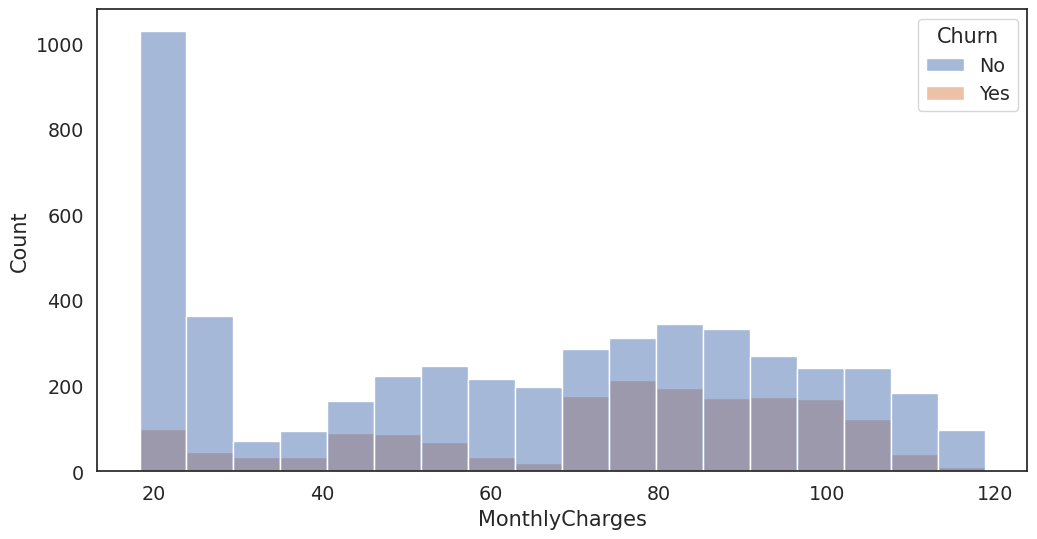

In [8]:
# overlaid histograms of monthly charges for churned and retained customers

sns.histplot(data=df, x='MonthlyCharges', hue='Churn')


Text(0, 0.5, 'Churn rate')

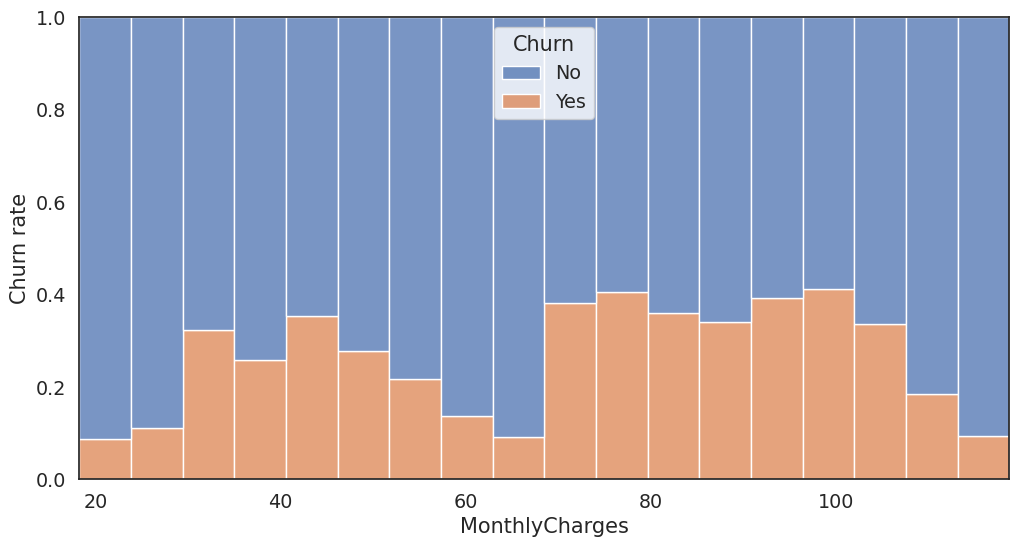

In [9]:
 # histogram of monthly charges, with churn rates

sns.histplot(data=df, x='MonthlyCharges', hue='Churn', multiple="fill").set_ylabel("Churn rate")

The situation becomes more complex as we add variables. What does the relationship between contract type, monthly charges, tenure, and churn look like?

We could make scatter plots of tenure vs monthly charges for each contract type, and colour the points by churn. Is there a pattern to the colours?

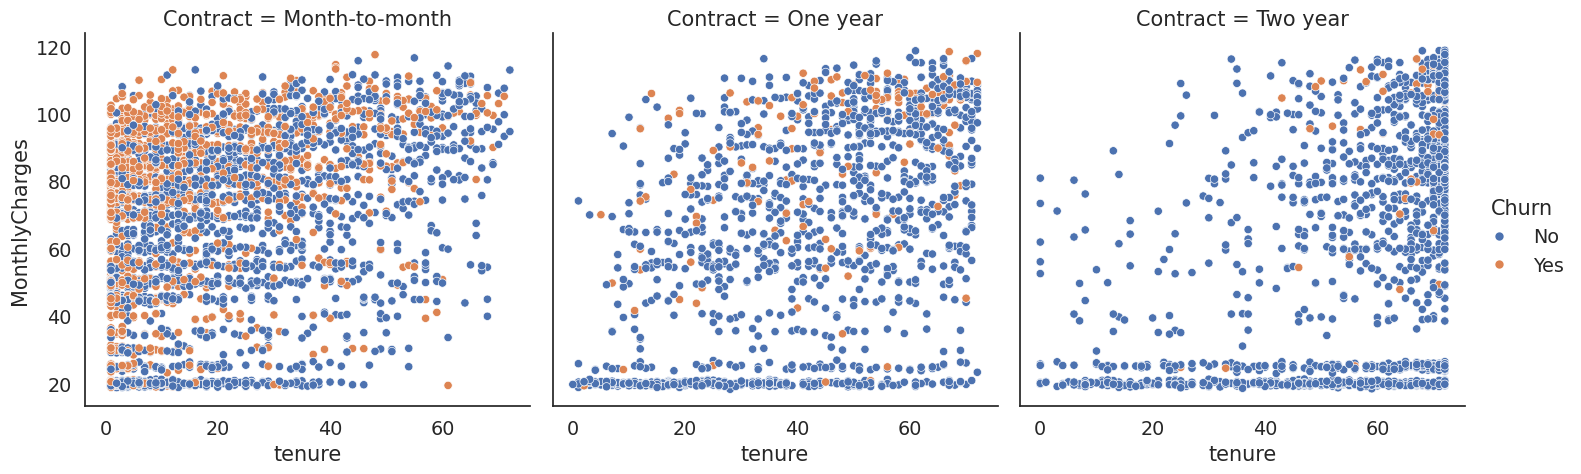

In [10]:
# scatter plot of tenure vs. monthly charges, hue by churn, facet by contract type

sns.relplot(data=df, x='tenure', y='MonthlyCharges', hue='Churn', col='Contract', kind='scatter')

There's "something" here, but it's starting to get indistinct with only a few variables.

What if... we could build a model find all the relationships for us, show us the important ones, and apply them systematically to predict churn?

## Predicting churn with PyCaret

PyCaret is a Python library that makes it easy to build and compare models. It's a great way to get started with predictive analytics because it takes care of a lot of the details for you.

We'll use PyCaret to predict customer churn. We'll start by setting up a PyCaret session.

In [11]:
# set up a PyCaret session to predict customer churn
from pycaret.classification import *

# set up the data for modelling
# df is the data, target is the column we want to predict, ignore_features is columns to ignore
# session_id is a random seed. If we all use the same seed, we'll get the same results (good for teaching)
s = setup(df, target='Churn', ignore_features=['customerID'], session_id=22804)

,Description,Value
0,Session id,22804
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(6691, 21)"
5,Transformed data shape,"(6691, 41)"
6,Transformed train set shape,"(4683, 41)"
7,Transformed test set shape,"(2008, 41)"
8,Ignore features,1
9,Numeric features,4


PyCaret has prepared the data for modelling. We told it that we're interested in predicting `Churn`, and we asked it to ignore the `customerID` column. With those few hints, PyCaret has identified the categorical, ordinal, and continuous variables and prepared the data for modelling.

There are some rows with missing values. We don't need to worry about them because PyCaret will take care of them for us. Read the table above and see if you can spot the missing values information, and what PyCaret is doing about it.


### Data modelling

The next step is to build a model to predict customer churn. There are lots of models to choose from. Why not try them all?

In [ ]:
# compare all models to find the best one
# this will take a little while

best_model = compare_models(sort='AUC')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,03:18:00
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8063,0.8462,0.8063,0.7978,0.7998,0.4740,0.4781,1.7120


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

### Building a model using logistic regression

Logistic regression seems to perform very well. It's not quite the best, but it's close. Since we'll meet logistic regression again in this module, let's use it.

In [ ]:
# build a logistic regression model to predict customer churn

# we set verbose=False to suppress output
# you are welcome to set verbose=True to see the run log and 10-fold cross-validation results
model = create_model('lr', verbose=False)
model

## Understanding the model

What are the most important features for predicting churn, according to the model?

In [ ]:
# show the most important features for predicting churn

plot_model(model, plot='feature')

We thought contract length was important, and it is. The most important feature is the month-to-month contract type. This is consistent with our earlier visualisations.

> [!activity] We expected that tenure would be important; is it? It doesn't appear in the top 10 features. Look very carefully at the plot of tenure and churn, split by contract type. Can you see why knowing tenure isn't so important in the model, once we know the contract type?


In [ ]:
# histograms of tenure for each contract type, hue by churn

sns.displot(data=df, x='tenure', hue='Churn', col='Contract', kind='hist', multiple='fill')

## Making predictions with the model

How do we use the model to predict churn? We'll add predictions to some of the data, so we can see predictions and actual churn side by side.

In [ ]:
# add predictions to the test set

predictions = predict_model(model)

# show the first few rows of the predictions
# Churn is the actual churn status
# prediction_label is the model's prediction
# prediction_score is the model's confidence in the prediction

predictions[['Churn', 'prediction_label', 'prediction_score']].head()

### Evaluating the model's performance

Visually comparing `Churn` to `prediction_label` for each row tells us whether the model is right or wrong about that row. But looking at the first few rows isn't a great indication of performance over the thousands of rows in the dataset.

We could of course calculate the percentage of correct predictions for the whole dataset, which is called the _accuracy_. This is such a common thing to do that PyCaret does it for us.

When we ran `predict_model`, PyCaret displayed a table of evaluation metrics. From this table we know that this model's accuracy is about 80%.

In practice, overall accuracy usually doesn't measure exactly what we care about. In later sections, we'll see how to evaluate models in other ways.


## Predicting churn for new customers

What about new customers? Can we use the model to predict whether they are likely to churn in the future?

We have another dataset with new customers. Let's load it and see if we can predict churn for them.

In [ ]:
# load the new customer data

new_custs = pd.read_csv('/content/telco_churn_new_custs.csv')
print(f"Rows: {len(new_custs)}")
print(f"Columns ({len(new_custs.columns)}):", ', '.join(new_custs.columns))
new_custs[['customerID', 'tenure', 'Dependents', 'TotalCharges', 'Contract']].head()

You'll notice that there is no `Churn` column in the new customer dataset. Wouldn't our call centre like to know which of these customers are likely to churn? Let's use the model to predict churn for these new customers.

In [ ]:
# there is no Churn column in the new_custs set
# so let's make one! 🔮

predictions_new_custs = predict_model(model, data=new_custs)
predictions_new_custs[['customerID', 'prediction_label', 'prediction_score']].head()

How do we know if this new "will churn" column is any good? There are a few options:

* We could wait and see if the customers actually churn.
* We could assume that the model is about as accurate for the new customers as it was for the old customers.
* Since this is a teaching example, we can peek inside `telco_churn_new_custs_actual.csv`, which has the actual churn status for these "new" customers.

We could write pandas code to add the actual churn status to the predictions, and calculate the accuracy ourselves. But it's easier to use PyCaret's `predict_model` function, which does it for us and gives the full range of evaluation metrics.

In [ ]:
# load the actual churn status for the new customers
new_custs_actual = pd.read_csv('/content/telco_churn_new_custs_actual.csv')
predictions_new_custs_actual = predict_model(model, data=new_custs_actual)

83% accurate, good!

Why is this "good"? It's not because 83% is a high number or a reasonable number. That's a business decision that we'll consider later in this module. It's good because 83% is similar to the 80% accuracy we saw when we evaluated the model on the training data. This means the model is performing consistently on new data.

## Exercises

1. What kind of model was the best at predicting churn? Use the `best_model` object to find out.
2. Make predictions for the new customers using the best model. Is it much better than the logistic regression model?
3. What is the most important feature for predicting churn according to the best model?
4. Use seaborn to visualise the relationship between an important feature and churn.

## References

* [PyCaret](https://pycaret.org/)
* [PyCaret documentation](https://pycaret.gitbook.io/docs)
* [Seaborn documentation](https://seaborn.pydata.org/)